# Investigating differences between styles by ingredient

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from beerai.config import DATA_DIR

In [5]:
%matplotlib inline

In [6]:
with pd.HDFStore(os.path.join(DATA_DIR, "interim/all_recipes.h5")) as store:
    core = store.get("core")
    ings = store.get("ingredients")

In [7]:
core.head()

,batch_size,boil_size,boil_time,brewer,efficiency,name,origin,recipe_file,src_abv,src_color,src_fg,src_ibu,src_og,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,,,,,,,
0,18.927059,21.198306,60.0,velkyal,0.75,dark island oir leann,brewtoad,recipes/brewtoad/dark-island-oir-leann.xml,NaN,NaN,NaN,NaN,NaN,6b,bjcp,blonde ale,1.0
1,22.712471,28.390588,60.0,wain thor,0.85,witbur,brewtoad,recipes/brewtoad/witbur.xml,NaN,NaN,NaN,NaN,NaN,6d,bjcp,american wheat or rye beer,1.0
2,20.819765,24.983718,60.0,btfielder,0.75,kolsch,brewtoad,recipes/brewtoad/kolsch-9285a4.xml,NaN,NaN,NaN,NaN,NaN,6c,bjcp,kölsch,1.0
3,18.927059,23.658824,60.0,viff brewing,0.75,amber alert,brewtoad,recipes/brewtoad/amber-alert-4.xml,NaN,NaN,NaN,NaN,NaN,10b,bjcp,american amber ale,1.0
4,18.927059,23.658824,60.0,pistolpete2,0.75,graff,brewtoad,recipes/brewtoad/graff-14.xml,NaN,NaN,NaN,NaN,NaN,20a,bjcp,fruit beer,1.0


In [8]:
map_files = glob.glob(os.path.join(DATA_DIR, "interim/*map.pickle"))
map_files = {os.path.basename(m)[:-10]: m for m in map_files}

maps = {}
for label, map_file in map_files.items():
    with open(map_file, "rb") as f:
        maps[label] = pickle.load(f)

In [9]:
ings["ferm_name"] = ings["ferm_name"].map(maps["ferm"])
ings["hop_name"] = ings["hop_name"].map(maps["hop"])
ings["yeast_name"] = ings["yeast_name"].map(maps["yeast"])
ings["misc_name"] = ings["misc_name"].map(maps["misc"])

In [10]:
styles = ["robust porter", "american stout"]

In [11]:
recipe_ids = core[core["style_name"].isin(styles)].index

In [12]:
stouts =  core.loc[recipe_ids].join(ings, how="left")

In [13]:
stouts.index.nunique()

16895

There are a couple of ways we can frame the question of "how do the fermentables differ between 2 styles":

1. What is the difference in likelihood/probability (sorry statisticians) that an ingredient will appear in the average recipe for a style?
2. What is the difference in the amount of fermentable in the average recipe for a style?
3. Probably a few others, but 1 and 2 are the most interesting for now.

Let's start with 1.

## How likely is a the average recipe for a style to include a specific fermentable?

In [27]:
by_style_ferm = stouts.reset_index().groupby(["style_name", "ferm_name"])
prob_ferm_by_style = by_style_ferm["id"].nunique() / stouts.index.nunique()
prob_ferm_by_style

style_name      ferm_name                          
american stout  2-row                                  0.240308
                6-row                                  0.007872
                abbey malt                             0.000533
                acidulated malt                        0.003492
                amber malt                             0.004321
                                                         ...   
robust porter   victory® malt                          0.024978
                vienna                                 0.015567
                warminster floor-malted maris otter    0.002723
                wheat, red                             0.000237
                white wheat                            0.035277
Name: id, Length: 242, dtype: float64

In [53]:
compare = prob_ferm_by_style.unstack().T
compare["tot"] = compare.sum(axis=1)
compare["diff"] = compare["american stout"] - compare["robust porter"]
compare["absdiff"] = (compare["american stout"] - compare["robust porter"]).abs()
compare = compare.sort_values("absdiff", ascending=True)
compare

style_name,american stout,robust porter,tot,diff,absdiff
ferm_name,,,,,
turbinado,0.001184,0.001184,0.002368,0.000000,0.000000
flaked rice,0.000474,0.000414,0.000888,0.000059,0.000059
dry malt extract - pilsen,0.006392,0.006452,0.012844,-0.000059,0.000059
carahell®,0.001598,0.001657,0.003255,-0.000059,0.000059
liquid malt extract - dark,0.020065,0.019947,0.040012,0.000118,0.000118
...,...,...,...,...,...
caramel/crystal 60l,0.089376,0.141462,0.230838,-0.052086,0.052086
flaked oats,0.154780,0.070790,0.225570,0.083989,0.083989
chocolate malt,0.120154,0.227405,0.347558,-0.107251,0.107251


Text(0.5, 0, 'Difference in probability')

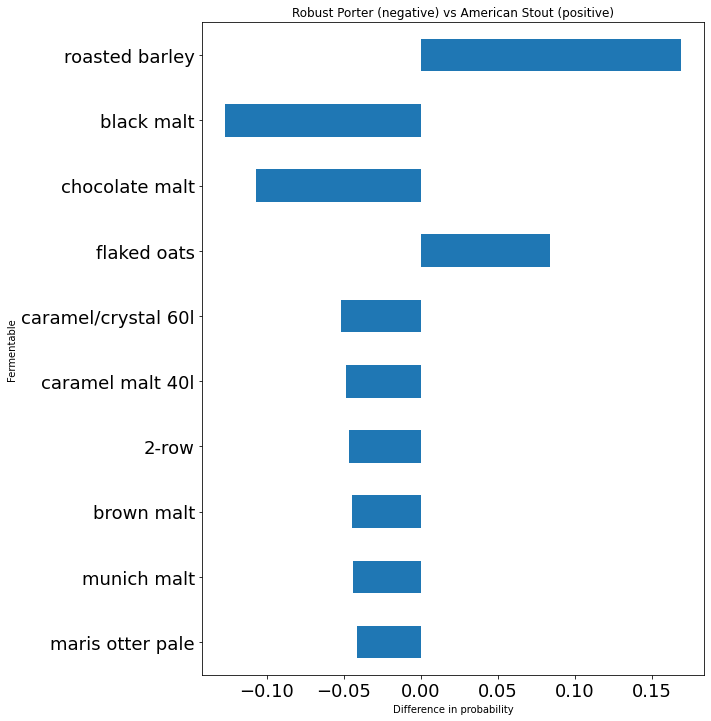

In [66]:
ax = compare.iloc[-10:, 3].plot(kind="barh", stacked=False, figsize=(9,12), fontsize=18)
ax.set_title("Robust Porter (negative) vs American Stout (positive)")
ax.set_ylabel("Fermentable")
ax.set_xlabel("Difference in probability")

Interpretation: The odds of finding ingredient X in category Y is n% higher than in category Z.

For example, the odds of finding roasted barley in an american stout is ~15% higher than in a robust porter.

# Adjust for Mass

The above calculation simply adds "1" for each appearance of a fermentable, regardless of how much of the fermentable is added, and would add multiple if it appeared in the recipe multiple times. What would likely be better would be to look at the percentage of the grain bill for each fermentable.

In [67]:
# Consideration - these are not scaled amounts. Need to scale fermentables first. Question is, do we scale 
# by total fermentables or by batch size (Liters). The difference is that one is a percentage of the,
# grain bill, the other is an amount per liter, which relates to the strength of the beer.
# I think the % is more interesting, not the per liter amount (per liter, the stronger beer will typically
# have more of almost everything).
by_style_ferm = stouts.groupby(["style_name", "ferm_name"]).ferm_amount.sum()
by_style = stouts.groupby(["style_name"]).ferm_amount.sum()
average_bill = by_style_ferm / by_style
average_bill

style_name      ferm_name                          
american stout  2-row                                  0.428363
                6-row                                  0.004346
                abbey malt                             0.000070
                acidulated malt                        0.000102
                amber malt                             0.000907
                                                         ...   
robust porter   victory® malt                          0.004919
                vienna                                 0.004128
                warminster floor-malted maris otter    0.002538
                wheat, red                             0.000065
                white wheat                            0.005850
Name: ferm_amount, Length: 242, dtype: float64

In [53]:
average_bill = average_bill.reset_index()

In [63]:
ferms_by_mass = average_bill.pivot_table(index="ferm_name", columns="style_name", dropna=False)

In [69]:
ferms_by_mass.columns = ferms_by_mass.columns.droplevel()

In [86]:
ferms_by_mass["tot"] = ferms_by_mass.sum(axis=1)
ferms_by_mass["dif"] = ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]
ferms_by_mass["absdif"] = (ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]).abs()

In [88]:
ferms_by_mass = ferms_by_mass.sort_values("absdif")

<AxesSubplot:ylabel='ferm_name'>

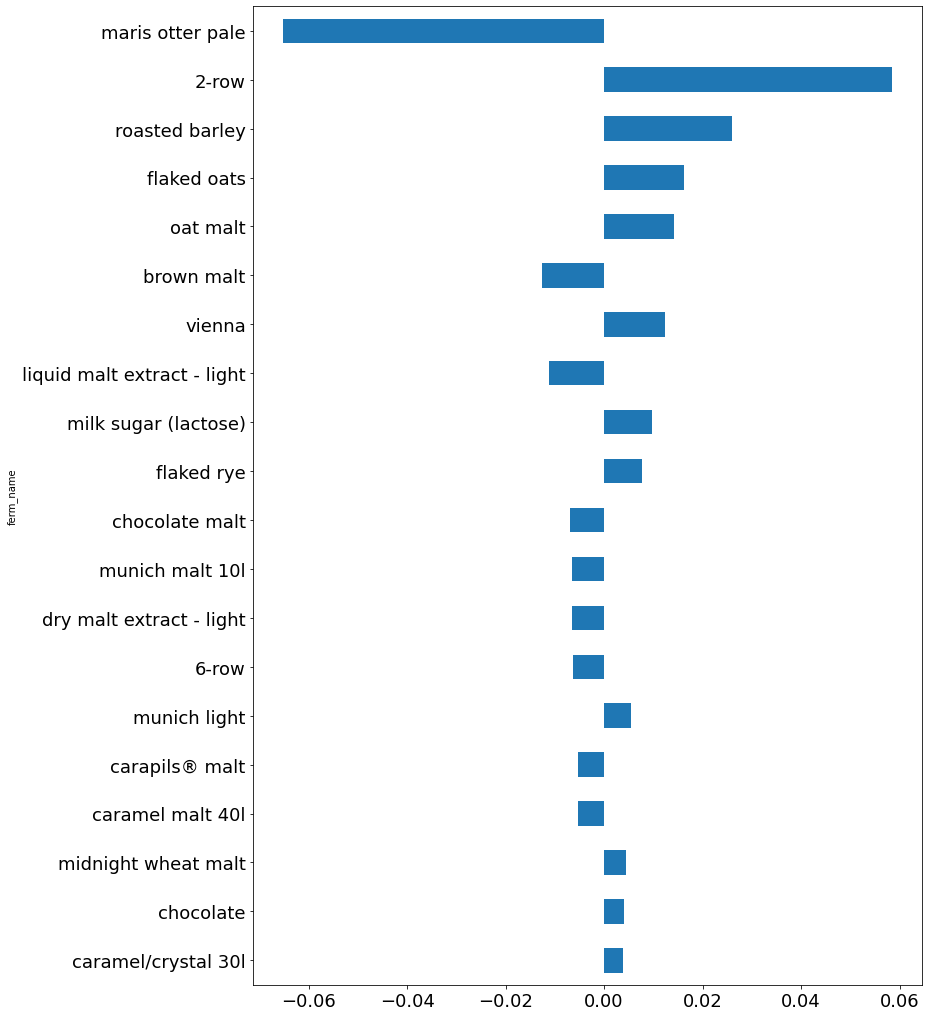

In [93]:
ferms_by_mass["dif"].iloc[-20:].plot(kind="barh", stacked=False, figsize=(12,18), fontsize=18)